# RadmonForest classifier with validation set

In order to more objectively assess the performance of our classifier, we will split-off a distinct validation set, consisting of 3 representative videos, that contain all behaviours to a useful degree. This also allows us to do a stratified train-test shuffle split, since we use the validation set to assess the actual performance.

In [83]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
import scikitplot as skplt
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.tree import DecisionTreeClassifier, plot_tree 

We import a labelled and norlazed frames. However, for now we removed all unlabelled frames, so that we don't end up with a huge imbalance on `not_defined` labels in our data set.

In [77]:
df = pd.read_hdf("merged_20210405.h5")
df = df[(df['behavior'] != "not_defined")]
df

bodyparts      head                               beak                         \
coords            x           y likelihood           x           y likelihood   
34600     -6.256115  133.140698   0.998600   28.458820  157.263363   0.974056   
34601      3.769024  145.079564   0.992194    1.435601  168.635165   0.998704   
34602      0.213448  148.213782   0.997358   -2.950560  176.568780   0.999940   
34603      2.762456  147.657923   0.999761  525.309970  604.796841   0.860005   
34604      2.196279  143.526230   0.997774   34.527160  149.529552   0.999838   
...             ...         ...        ...         ...         ...        ...   
38031      4.897417  177.600705   0.999900   30.771665  203.767842   0.999990   
38032      1.005224  169.487090   0.999758   16.386927  209.473704   0.999982   
38033      1.033190  170.307134   0.999995   11.928434  205.935297   0.999999   
38034     -1.618751  173.363199   0.999999   16.374546  204.249601   1.000000   
38035     -3.469847  172.069851   1.000000   16.637790  200.859973   1.000000   

bodyparts  left_neck                        right_neck  ...       body  \
coords             x           y likelihood          x  ... likelihood   
34600      39.766114   99.337532   1.000000 -39.766114  ...   0.999989   
34601      39.091074  102.566764   0.999997 -39.091074  ...   0.999955   
34602      39.161616  105.930661   0.999996 -39.161616  ...   0.999971   
34603      38.959007  106.304114   0.999999 -38.959007  ...   0.999973   
34604      39.876856  103.607613   1.000000 -39.876856  ...   0.999987   
...              ...         ...        ...        ...  ...        ...   
38031      40.332658  120.383899   0.999997 -40.332658  ...   0.999998   
38032      40.241152  121.762393   0.999998 -40.241152  ...   0.999998   
38033      41.282461  123.487411   1.000000 -41.282461  ...   0.999998   
38034      40.873566  124.888961   0.999999 -40.873566  ...   0.999997   
38035      41.394312  126.094337   0.999999 -41.394312  ...   0.999999   

bodyparts       tail                          middle_neck              \
coords             x           y likelihood             x           y   
34600      16.614607 -106.037636   0.999988 -6.559721e-15   98.676032   
34601      17.690069 -106.504741   0.999975  6.983719e-15  101.558517   
34602      19.303123 -104.565719   0.999963  1.584214e-14  104.192925   
34603      16.542397 -105.026859   0.999965  1.052610e-14  102.874054   
34604      19.000453 -110.547172   0.999992 -1.431422e-14  100.011360   
...              ...         ...        ...           ...         ...   
38031      30.366276 -111.999133   0.999990  2.690406e-14  125.305453   
38032      26.714623 -110.071315   0.999994  2.121088e-14  125.353381   
38033      29.245919 -108.853585   0.999989  3.990525e-15  128.161332   
38034      26.189131 -106.770526   0.999983  4.046852e-14  130.237987   
38035      25.777393 -109.251950   0.999992 -4.745602e-14  129.118538   

bodyparts rotation_angle  \
coords                     
34600        -127.844964   
34601        -127.805934   
34602        -128.614585   
34603        -127.998885   
34604        -128.414942   
...                  ...   
38031        -133.738577   
38032        -132.919632   
38033        -133.700335   
38034        -133.262292   
38035        -133.115777   

bodyparts                                                              file_name  \
coords                                                                             
34600      233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
34601      233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
34602      233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
34603      233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
34604      233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
...                                                                          ...

We have a set of files as distinct sessions results we hand-picked as our test-set, since they are representative of real worlds results and provide a good distribution of different behaviours.

In [78]:
test_files = [
    "233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    "877_100ms_gopro_cut_day3DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    
    "251_100ms_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    "418_500ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
]

df_test = df[df['file_name'].isin(test_files)]
df_train_valid = df[~df['file_name'].isin(test_files)]

test_share = len(df_test) / len(df_train_valid)
print(f"Percentage of test frames of overall data set: {test_share}")

Percentage of test frames of overall data set: 0.20230696785413652


The 2D coordinates of all bodyparts are used as features. We specify them manually, since the data frame also contains other data and pre-aggregated data from pre-processing steps. 

Train- and validation-set are taken and split from the remaining data in a random fashion, excluding the frames taken for the test-set.

In [79]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]

y = df_train_valid['behavior']
x = df_train_valid[features].values

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state=13)

x_test = df_test[features].values
y_test = df_test['behavior']

`RandomForestClassifier` is trained in its default configuration. This means e.g. 100 trees in the forest (which is the default) and same class weights for all classes.

In [34]:
clf = RandomForestClassifier(random_state=0, verbose=1)
clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.9min finished


RandomForestClassifier(random_state=0, verbose=1)

In [38]:
filename = 'random_forest20210517.sav'
pickle.dump(clf, open(filename, 'wb'))

## Performance on validation set

In [40]:
predictions = clf.predict(x_valid)
print(classification_report(y_valid, predictions))
print(roc_auc_score(y_valid, clf.predict_proba(x_valid), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


                   precision    recall  f1-score   support

    back_preening       0.98      0.98      0.98      3960
        body_pump       0.92      0.85      0.89      1209
           eating       1.00      1.00      1.00     57342
 feather_clapping       0.93      0.97      0.95      3807
   front_preening       0.98      0.99      0.98      7524
       head_shake       0.99      0.81      0.89      1647
scratch_with_feet       0.99      0.97      0.98       797
         standing       0.99      1.00      0.99     61044
 standing_shaking       0.98      0.99      0.99      1713
       tail_shake       0.98      0.78      0.87      1231
          walking       0.96      0.95      0.95      3708

         accuracy                           0.99    143982
        macro avg       0.97      0.94      0.95    143982
     weighted avg       0.99      0.99      0.99    143982



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


0.9984338658179677


## Performance on test set

In [41]:
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, clf.predict_proba(x_test), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


                   precision    recall  f1-score   support

    back_preening       0.55      0.77      0.64      2168
        body_pump       0.25      0.35      0.29       355
           eating       0.98      0.93      0.96     69125
 feather_clapping       0.55      0.63      0.59      2263
   front_preening       0.29      0.51      0.37      4770
       head_shake       0.11      0.21      0.14       537
scratch_with_feet       0.23      0.01      0.02      1338
         standing       0.86      0.88      0.87     54374
 standing_shaking       0.03      0.00      0.00       401
       tail_shake       0.62      0.52      0.57       483
          walking       0.53      0.44      0.48      9828

         accuracy                           0.84    145642
        macro avg       0.45      0.48      0.45    145642
     weighted avg       0.85      0.84      0.84    145642



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


0.8605790078606032


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

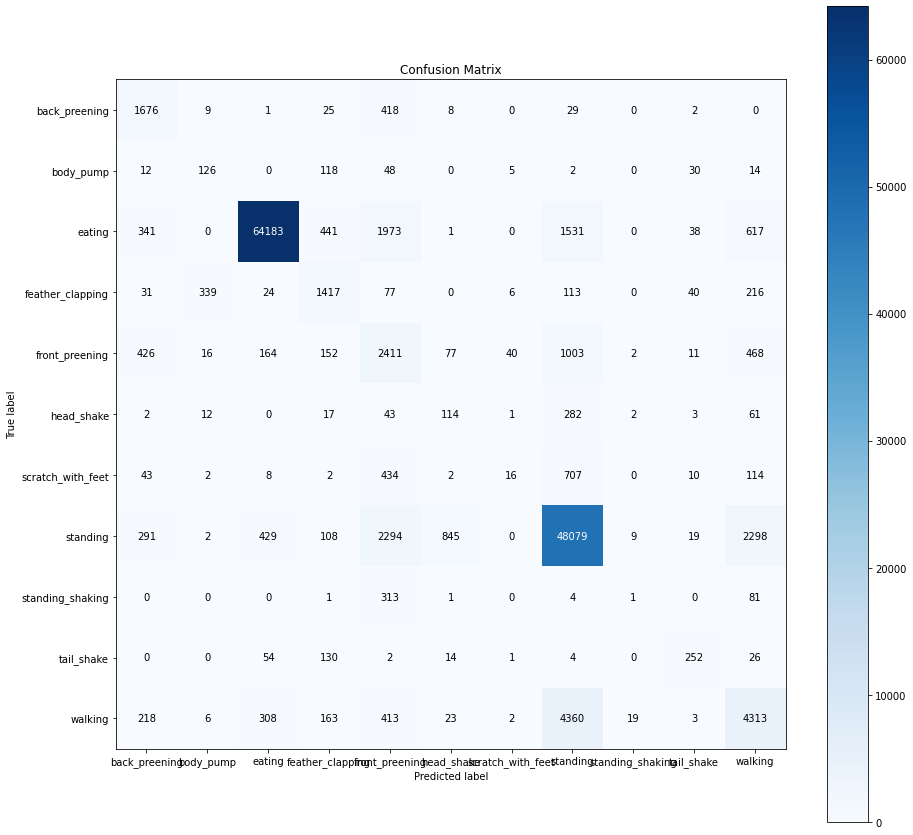

In [42]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, figsize=(15, 15))  

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

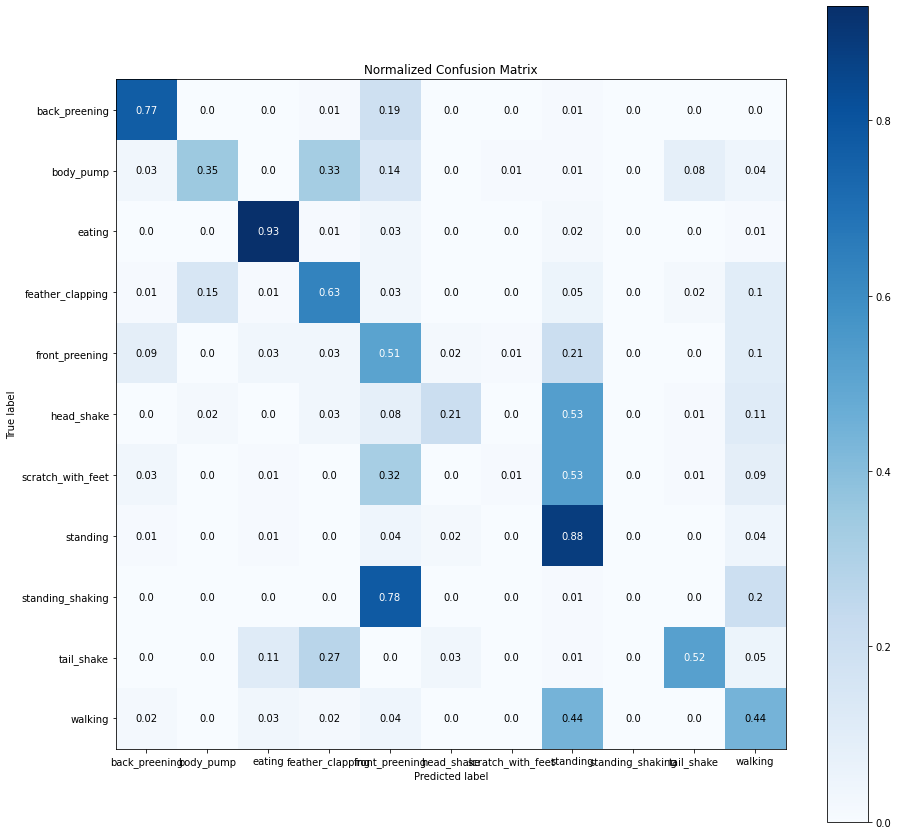

In [43]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, figsize=(15, 15), normalize=True)  

# Using class weights
We use again random forest, but this use class weights to combat the unbalanced data.

In [44]:
clf_cw = RandomForestClassifier(random_state=0, class_weight='balanced')
clf_cw.fit(x_train, y_train)

predictions = clf_cw.predict(x_valid)
print(classification_report(y_valid, predictions))

predictions = clf_cw.predict(x_test)
print(classification_report(y_test, predictions))

                   precision    recall  f1-score   support

    back_preening       0.98      0.98      0.98      3960
        body_pump       0.93      0.84      0.89      1209
           eating       1.00      1.00      1.00     57342
 feather_clapping       0.93      0.98      0.95      3807
   front_preening       0.99      0.98      0.99      7524
       head_shake       1.00      0.80      0.89      1647
scratch_with_feet       1.00      0.97      0.99       797
         standing       0.99      1.00      0.99     61044
 standing_shaking       0.98      0.98      0.98      1713
       tail_shake       0.98      0.78      0.87      1231
          walking       0.97      0.94      0.95      3708

         accuracy                           0.99    143982
        macro avg       0.98      0.93      0.95    143982
     weighted avg       0.99      0.99      0.99    143982

                   precision    recall  f1-score   support

    back_preening       0.63      0.79      0.70    

In [46]:
print(roc_auc_score(y_test, clf_cw.predict_proba(x_test), multi_class='ovo', average='macro'))

0.863026631069238


# Decision Tree

In [81]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train, y_train)

predictions = dt.predict(x_valid)
print(classification_report(y_valid, predictions))
print(roc_auc_score(y_valid, dt.predict_proba(x_valid), multi_class='ovo', average='macro'))

predictions = dt.predict(x_test)
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, dt.predict_proba(x_test), multi_class='ovo', average='macro'))

                   precision    recall  f1-score   support

    back_preening       0.91      0.91      0.91      3960
        body_pump       0.77      0.71      0.74      1209
           eating       0.99      0.99      0.99     57342
 feather_clapping       0.85      0.85      0.85      3807
   front_preening       0.90      0.90      0.90      7524
       head_shake       0.69      0.65      0.67      1647
scratch_with_feet       0.85      0.87      0.86       797
         standing       0.98      0.98      0.98     61044
 standing_shaking       0.92      0.93      0.93      1713
       tail_shake       0.66      0.60      0.63      1231
          walking       0.78      0.77      0.78      3708

         accuracy                           0.96    143982
        macro avg       0.85      0.83      0.84    143982
     weighted avg       0.96      0.96      0.96    143982

0.9082834787600927
                   precision    recall  f1-score   support

    back_preening       0.43     

[Text(108.47966788205015, 216.00947368421052, 'X[4] <= 32.411\ngini = 0.656\nsamples = 575924\nvalue = [15593, 4676, 230773, 15373, 30699, 6606, 3049, 243036\n6500, 4889, 14730]'),
 Text(31.483146690616856, 213.1484210526316, 'X[13] <= -119.122\ngini = 0.239\nsamples = 259486\nvalue = [6597, 594, 225997, 7504, 5420, 89, 1131, 7345, 890\n1962, 1957]'),
 Text(10.336795089982074, 210.28736842105263, 'X[16] <= -75.71\ngini = 0.068\nsamples = 232032\nvalue = [351, 152, 223936, 3062, 457, 30, 415, 2200, 19, 832\n578]'),
 Text(1.8195097461506664, 207.42631578947368, 'X[16] <= -80.7\ngini = 0.494\nsamples = 1879\nvalue = [126, 95, 128, 1315, 88, 2, 3, 77, 1, 38, 6]'),
 Text(0.909472605867852, 204.56526315789475, 'X[8] <= 55.632\ngini = 0.328\nsamples = 1475\nvalue = [89, 86, 9, 1202, 47, 2, 1, 17, 0, 19, 3]'),
 Text(0.32796128718650963, 201.7042105263158, 'X[0] <= -53.713\ngini = 0.237\nsamples = 1282\nvalue = [56, 19, 9, 1117, 42, 1, 1, 15, 0, 19, 3]'),
 Text(0.10463045084555748, 198.84315789

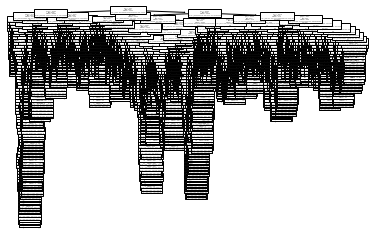

In [84]:
plot_tree(dt)

# Multi-frame Classification

This will use the same approach and models as the previous runs, but this time, transform multiple frames into feature dimensions (`noFrames * noFeatures = dim(inputVector)`). 

The modal of the multi-frame label vector is used to label the time slice (aka dominant behaviour in time slice).

In [47]:
from tsai.all import *

In [48]:
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

x_ts, y_ts = SlidingWindow(60, get_x=features, get_y='behavior', y_func=y_func)(df_train_valid)
x_test_ts, y_test_ts = SlidingWindow(60, get_x=features, get_y='behavior', y_func=y_func)(df_test)

In [62]:
x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))

In [61]:
x_test_ts = x_test_ts.reshape((-1, x_test_ts.shape[1] * x_test_ts.shape[2]))

In [63]:
x_ts_train, x_ts_valid, y_ts_train, y_ts_valid = train_test_split(x_ts, y_ts, test_size = 0.2, random_state=13)

In [64]:
clf_ts = RandomForestClassifier(random_state=0, verbose=1)
clf_ts.fit(x_ts_train, y_ts_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 297.0min finished


RandomForestClassifier(random_state=0, verbose=1)

In [65]:
predictions = clf_ts.predict(x_ts_valid)
print(classification_report(y_ts_valid, predictions))

predictions = clf_ts.predict(x_test_ts)
print(classification_report(y_test_ts, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.2s finished


                   precision    recall  f1-score   support

    back_preening       0.97      0.98      0.98      3875
        body_pump       0.96      0.85      0.90      1232
           eating       1.00      1.00      1.00     57491
 feather_clapping       0.89      0.98      0.93      3765
   front_preening       0.98      0.99      0.99      7621
       head_shake       0.99      0.87      0.92      1640
scratch_with_feet       0.99      0.93      0.96       813
         standing       1.00      1.00      1.00     60924
 standing_shaking       1.00      1.00      1.00      1693
       tail_shake       0.99      0.83      0.90      1223
          walking       0.99      0.98      0.99      3693

         accuracy                           0.99    143970
        macro avg       0.98      0.95      0.96    143970
     weighted avg       0.99      0.99      0.99    143970



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.4s finished


                   precision    recall  f1-score   support

    back_preening       0.73      0.86      0.79      2168
        body_pump       0.30      0.44      0.36       355
           eating       0.98      0.93      0.95     69065
 feather_clapping       0.63      0.66      0.65      2263
   front_preening       0.31      0.61      0.41      4770
       head_shake       0.13      0.01      0.03       537
scratch_with_feet       0.00      0.00      0.00      1338
         standing       0.84      0.89      0.87     54374
 standing_shaking       0.00      0.00      0.00       401
       tail_shake       0.75      0.24      0.37       483
          walking       0.61      0.44      0.51      9828

         accuracy                           0.85    145582
        macro avg       0.48      0.46      0.45    145582
     weighted avg       0.85      0.85      0.85    145582



In [66]:
pickle.dump(clf_ts, open("random_forest_60", 'wb'))

In [68]:
print(roc_auc_score(y_test_ts, clf_ts.predict_proba(x_test_ts), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished


0.8482449745689633


## 30 Frames

In [70]:
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

x_ts, y_ts = SlidingWindow(30, get_x=features, get_y='behavior', y_func=y_func)(df_train_valid)
x_test_ts, y_test_ts = SlidingWindow(30, get_x=features, get_y='behavior', y_func=y_func)(df_test)
x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))
x_test_ts = x_test_ts.reshape((-1, x_test_ts.shape[1] * x_test_ts.shape[2]))
x_ts_train, x_ts_valid, y_ts_train, y_ts_valid = train_test_split(x_ts, y_ts, test_size = 0.2, random_state=13)

clf_ts = RandomForestClassifier(random_state=0, verbose=1)
clf_ts.fit(x_ts_train, y_ts_train)

predictions = clf_ts.predict(x_ts_valid)
print(classification_report(y_ts_valid, predictions))

predictions = clf_ts.predict(x_test_ts)
print(classification_report(y_test_ts, predictions))

print(roc_auc_score(y_test_ts, clf_ts.predict_proba(x_test_ts), multi_class='ovo', average='macro'))

pickle.dump(clf_ts, open("random_forest_30", 'wb'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 182.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished


                   precision    recall  f1-score   support

    back_preening       0.97      0.98      0.97      3901
        body_pump       0.93      0.84      0.88      1187
           eating       1.00      1.00      1.00     57464
 feather_clapping       0.88      0.98      0.93      3768
   front_preening       0.98      0.99      0.98      7546
       head_shake       0.98      0.83      0.90      1633
scratch_with_feet       0.99      0.94      0.96       809
         standing       0.99      1.00      1.00     61045
 standing_shaking       1.00      1.00      1.00      1656
       tail_shake       0.99      0.77      0.86      1245
          walking       0.98      0.98      0.98      3722

         accuracy                           0.99    143976
        macro avg       0.97      0.93      0.95    143976
     weighted avg       0.99      0.99      0.99    143976



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished


                   precision    recall  f1-score   support

    back_preening       0.69      0.85      0.76      2168
        body_pump       0.30      0.47      0.37       355
           eating       0.98      0.93      0.95     69095
 feather_clapping       0.62      0.65      0.64      2263
   front_preening       0.29      0.57      0.39      4770
       head_shake       0.13      0.04      0.07       537
scratch_with_feet       0.00      0.00      0.00      1338
         standing       0.84      0.89      0.86     54374
 standing_shaking       0.00      0.00      0.00       401
       tail_shake       0.87      0.37      0.52       483
          walking       0.59      0.43      0.50      9828

         accuracy                           0.85    145612
        macro avg       0.48      0.47      0.46    145612
     weighted avg       0.85      0.85      0.85    145612



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished


0.8555350872076325


# KNN Classification

Trying out KNN with 8 frames.
(TODO: KNN with 1 frame)

In [71]:
# TODO: extract function into module

def create_ts(df_train_valid, df_test, features, windows_size):
    def y_func(o): 
        return scipy.stats.mode(o, axis=1).mode.ravel()

    x_ts, y_ts = SlidingWindow(windows_size, get_x=features, get_y='behavior', y_func=y_func)(df_train_valid)
    x_test_ts, y_test_ts = SlidingWindow(windows_size, get_x=features, get_y='behavior', y_func=y_func)(df_test)
    x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))
    x_test_ts = x_test_ts.reshape((-1, x_test_ts.shape[1] * x_test_ts.shape[2]))
    x_ts_train, x_ts_valid, y_ts_train, y_ts_valid = train_test_split(x_ts, y_ts, test_size = 0.2, random_state=13)
    
    return  x_ts_train, x_ts_valid, x_test_ts, y_ts_train, y_ts_valid, y_test_ts


In [72]:
x_ts_train, x_ts_valid, x_test_ts, y_ts_train, y_ts_valid, y_test_ts = create_ts(df_train_valid, df_test, features, 8)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_ts_train, y_ts_train)


KNeighborsClassifier()

In [74]:
predictions = knn.predict(x_ts_valid)
print(classification_report(y_ts_valid, predictions))

predictions = knn.predict(x_test_ts)
print(classification_report(y_test_ts, predictions))

                   precision    recall  f1-score   support

    back_preening       0.92      0.93      0.92      3826
        body_pump       0.84      0.65      0.73      1191
           eating       1.00      1.00      1.00     57408
 feather_clapping       0.91      0.82      0.86      3746
   front_preening       0.96      0.96      0.96      7585
       head_shake       0.93      0.88      0.91      1645
scratch_with_feet       0.92      0.90      0.91       805
         standing       0.99      1.00      0.99     61110
 standing_shaking       0.93      0.99      0.96      1711
       tail_shake       0.83      0.59      0.69      1230
          walking       0.88      0.93      0.91      3723

         accuracy                           0.98    143980
        macro avg       0.92      0.88      0.89    143980
     weighted avg       0.98      0.98      0.98    143980

                   precision    recall  f1-score   support

    back_preening       0.71      0.72      0.71    

In [75]:
for i in [10, 15, 20]:
    print("=========================================")
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_ts_train, y_ts_train)
    predictions = knn.predict(x_ts_valid)
    print(classification_report(y_ts_valid, predictions))
    predictions = knn.predict(x_test_ts)
    print(classification_report(y_test_ts, predictions))
    print("=========================================")

10
                   precision    recall  f1-score   support

    back_preening       0.92      0.91      0.92      3826
        body_pump       0.83      0.61      0.70      1191
           eating       0.99      1.00      1.00     57408
 feather_clapping       0.89      0.78      0.83      3746
   front_preening       0.94      0.95      0.95      7585
       head_shake       0.92      0.81      0.86      1645
scratch_with_feet       0.93      0.87      0.90       805
         standing       0.98      0.99      0.99     61110
 standing_shaking       0.90      0.98      0.94      1711
       tail_shake       0.79      0.48      0.60      1230
          walking       0.86      0.89      0.87      3723

         accuracy                           0.97    143980
        macro avg       0.91      0.84      0.87    143980
     weighted avg       0.97      0.97      0.97    143980

                   precision    recall  f1-score   support

    back_preening       0.72      0.71      0.71 